In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Install and Import needed libraries###

In [ ]:
!pip install "dask[dataframe]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install cartopy
import cartopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.8 MB 4.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 39.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 51.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 45.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 44.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 46 kB 3.8 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m

In [ ]:
!pip install proj

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 66 kB 438 kB/s 


In [ ]:
!pip install basemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 864 kB 4.7 MB/s 
     |████████████████████████████████| 30.5 MB 2.3 MB/s 
     |████████████████████████████████| 6.3 MB 41.3 MB/s 


In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
#sys.path.insert(0, '/global/homes/x/xzheng/python_lib/')
from netCDF4 import Dataset
import matplotlib as mpl 
import matplotlib.colors as colors
#os.environ['PROJ_LIB'] = r'/global/cfs/cdirs/e3sm/xzheng/conda/pkgs/proj-7.2.0-h277dcde_2/share/'
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from sklearn import preprocessing
from statistics import mean
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score

###Read our data as an xarray##

In [ ]:
#path2 = ('/content/drive/MyDrive/Data/mock.nc')
#path2 = ('/content/drive/MyDrive/Private/Image_Similarity/mock1.nc')
#path2 = ('/content/drive/MyDrive/Data/mock_v2.nc')
#path2 = ('/content/drive/MyDrive/Data/mock_v2.1.nc')
#path2 = ('/content/drive/MyDrive/Data/mock_v3.nc')
#path2 = ('/content/drive/MyDrive/Data/mock_v3.1.nc')
#path2 = ('/content/drive/MyDrive/Data/mock_v4.nc')
path2 = ('/content/drive/MyDrive/Data/ERA5_meteo_sfc_2021_daily.nc')
#path2 = ('/content/drive/MyDrive/Data/ERA5_meteo_sfc_2021_daily_smalldomain.nc')
#path2 = ('/content/drive/MyDrive/Data/ERA5_meteo_sfc_2021_hourly.nc')
#path2 = ('/content/drive/MyDrive/Data/ERA5_meteo_sfc_2021_hourly_smalldomain.nc')
data = xr.open_dataset(path2, decode_times=False) #To view the date as integers of 0, 1, 2,....
#data = xr.open_dataset(path2)# decode_times=False) #To view the date as integers of 0, 1, 2,....
#data5 = xr.open_dataset(path2) # To view time in datetime format
data

<xarray.Dataset>
Dimensions:    (time: 365, longitude: 41, latitude: 41)
Coordinates:
  * time       (time) float64 0.0 1.0 2.0 3.0 4.0 ... 361.0 362.0 363.0 364.0
  * longitude  (longitude) float32 -33.0 -32.75 -32.5 ... -23.5 -23.25 -23.0
  * latitude   (latitude) float32 43.0 42.75 42.5 42.25 ... 33.5 33.25 33.0
Data variables:
    sp         (time, latitude, longitude) float64 ...
    sst        (time, latitude, longitude) float64 ...
    u10        (time, latitude, longitude) float64 ...
    v10        (time, latitude, longitude) float64 ...
    sshf       (time, latitude, longitude) float64 ...
    slhf       (time, latitude, longitude) float64 ...
    t2m        (time, latitude, longitude) float64 ...
Attributes:
    title:          Daily variables from ERA5 hourly data
    history:        Wed Mar 23 12:01:11 2022: ncrcat ERA5_meteo_sfc_2021_01-0...
    Input dataset:  /global/cscratch1/sd/xzheng/ENA/rawdata/ERA5_meteo_sfc_20...
    NCO:            netCDF Operators version 5.0.1 (Homepage = http://nco.sf....

###Preprocessing###


1.   Apply Physics-based NaN imputation
2.   Transform and Normalize data
3.   PCA reduce data





In [ ]:
#Function to input NaN values across variables
def null_fill(input):

  dask_df = input.to_dask_dataframe(dim_order=None, set_index=False)
  pd_df = dask_df.compute()
  pd_df1 = pd_df.iloc[:, 3:]
  df2 = pd_df1[pd_df1.isnull().any(axis=1)]
  lst = list(df2.index.values)
  df2.loc[:] = np.nan
  dt = pd.concat([pd_df1, df2], axis=0)
  dt3 = dt[~dt.index.duplicated(keep='last')]
  dt4 = dt3[['sst', 'sp', 'u10', 'v10', 'sshf', 'slhf', 't2m']]
  pd_df4 = pd_df.iloc[:, 0:5]
  dff = pd_df4[['time', 'longitude', 'latitude', 'sst']]
  df = pd.merge(dff, dt4, left_index=True, right_index=True).drop('sst_y', axis=1)
  df.rename(columns={'sst_x':'sst'}, inplace=True)
  df_rows = pd.DataFrame(df).set_index(["time", "longitude", "latitude"])
  data = xr.Dataset.from_dataframe(df_rows)
  df_rows = pd.DataFrame(df).set_index(["time", "longitude", "latitude"])
  data = xr.Dataset.from_dataframe(df_rows)

  return data

In [ ]:
data = null_fill(data)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [ ]:
def datatransformation(data):
        dask_df = data.to_dask_dataframe(dim_order=None, set_index=False)
        pd_df = dask_df.compute()

        for i in pd_df.columns:
          if pd_df[i].isna().sum() > 0:
            pd_df[i].fillna(value=pd_df[i].mean(), inplace=True)
        
        #col = 'time','lat','lon'
        col = 'time','latitude','longitude'
        fin_df = pd_df.loc[:, ~pd_df.columns.isin(col)]

        trans_data = pd.DataFrame()
        for j in fin_df.columns:
          for i in range(0,pd_df.shape[0]):
              c=(j + '(' + str(pd_df.latitude[i])+','+str(pd_df.longitude[i]) + ')')
              trans_data.loc[pd_df.time[i], c] = pd_df[j][i]

        return trans_data

def datanormalization(input):
  x = input.values #returns a numpy array
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  trans_data = pd.DataFrame(x_scaled, columns=input.columns, index=input.index)
        
  return trans_data

In [ ]:
#trans_data1 = datatransformation(data)
trans_data = datanormalization(trans1_data)

In [ ]:
#trans_data.to_csv("/content/drive/MyDrive/Private/Image_Similarity/daily_trans.csv")

In [ ]:
#norm_data = datanormalization(trans_data)

In [ ]:
#norm_data.to_csv("/content/drive/MyDrive/Private/Image_Similarity/daily_trans_norm.csv")

In [ ]:
# trans_data = pd.read_csv("/content/drive/MyDrive/Private/Image_Similarity/daily_trans.csv")
trans_data = pd.read_csv("/content/drive/MyDrive/Private/Image_Similarity/daily_trans_norm.csv")
trans_data = trans_data.iloc[:,1:]
trans_data.head(3)

sst(33.0,-33.0)  sst(33.25,-33.0)  sst(33.5,-33.0)  sst(33.75,-33.0)  \
0         0.248875          0.251932         0.218729          0.167344   
1         0.258726          0.279664         0.243431          0.190116   
2         0.240647          0.263094         0.258533          0.200309   

   sst(34.0,-33.0)  sst(34.25,-33.0)  sst(34.5,-33.0)  sst(34.75,-33.0)  \
0         0.118699          0.098418         0.119796          0.130408   
1         0.138874          0.113119         0.128353          0.133286   
2         0.129656          0.091264         0.112380          0.124466   

   sst(35.0,-33.0)  sst(35.25,-33.0)  ...  t2m(40.75,-23.0)  t2m(41.0,-23.0)  \
0         0.137461          0.151515  ...          0.195031         0.185714   
1         0.145086          0.164616  ...          0.258879         0.255773   
2         0.145409          0.160901  ...          0.305736         0.299503   

   t2m(41.25,-23.0)  t2m(41.5,-23.0)  t2m(41.75,-23.0)  t2m(42.0,-23.0)  \
0          0.178300         0.172120          0.154563         0.143675   
1          0.257252         0.258178          0.246343         0.243416   
2          0.298483         0.299952          0.292361         0.286533   

   t2m(42.25,-23.0)  t2m(42.5,-23.0)  t2m(42.75,-23.0)  t2m(43.0,-23.0)  
0          0.146293         0.156671          0.173913         0.195476  
1          0.248745         0.258991          0.272482         0.286063  
2          0.292380         0.303016          0.319956         0.337499  

[3 rows x 11767 columns]

In [ ]:
# norm_data = pd.read_csv("/content/drive/MyDrive/Private/Image_Similarity/daily_trans_norm.csv")
# norm_data = norm_data.iloc[:,1:]
# #norm_data

In [ ]:
pca = PCA(n_components=11)
principalComponents = pca.fit_transform(trans_data)
trans_data = pd.DataFrame(data = principalComponents
             , columns = ['PC_1', 'PC_2', 'PC_3','PC_4', 'PC_5', 'PC_6','PC_7', 'PC_8', 'PC_9','PC_10', 'PC_11'])

In [ ]:
trans_data

PC_1       PC_2       PC_3       PC_4      PC_5      PC_6      PC_7  \
0    14.322892   5.597010  -5.206832  12.185961 -0.827931 -4.527164  0.701693   
1    14.946676  -1.529004  -2.361471  18.377357  0.187829 -4.077321 -1.745596   
2    15.516234  -8.947399   1.701612  21.752635 -4.862390 -2.274503 -1.094145   
3    16.381521 -10.849598   3.896199  17.910412 -7.842916 -1.184885 -4.861774   
4    16.717359  -6.233022   7.235995  21.983062 -7.474110 -5.329982 -5.206158   
..         ...        ...        ...        ...       ...       ...       ...   
360  10.050502 -20.973653  -2.572095  -1.211986  4.149352  2.398439 -4.862138   
361  10.796356 -25.935865  -5.352422   2.151608  4.051316  2.236251 -0.613757   
362  14.391105 -18.924465   8.941200   2.599492  4.534573  2.370861  2.825248   
363  16.281829 -20.370831  15.464218   6.119504  5.520241  2.664726 -0.933134   
364  16.646688 -14.630541  22.664855  -0.072299  2.301754  3.259306  1.562434   

         PC_8      PC_9     PC_10     PC_11  
0    0.908252  1.891758 -0.469721  0.609918  
1    3.100452  3.019583  2.237207  2.074107  
2    4.251742  2.157962  4.463349  1.556604  
3    3.578637 -3.824008  2.281738 -1.110917  
4    4.893698 -1.459008  1.196417 -0.100991  
..        ...       ...       ...       ...  
360  1.228702  4.588081  0.714266 -1.238248  
361  0.826958  6.883928  0.022833 -0.283555  
362  3.120387  2.049616 -3.131177  3.030096  
363 -0.064049  1.741301 -0.471218  3.745047  
364 -1.547208  2.784359  1.693320  3.048996  

[365 rows x 11 columns]

###Clustering algorithm implementation###

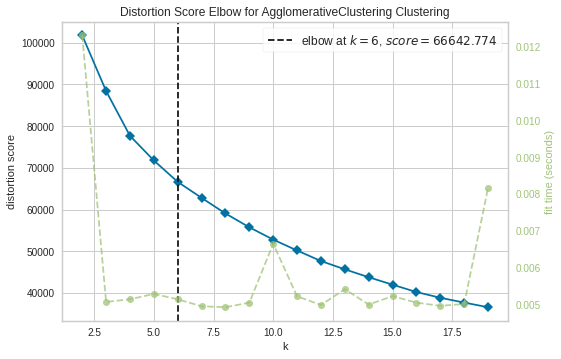

In [ ]:
# Elbow Method for Agglomerative Clustering
model = AgglomerativeClustering()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,20), timings= True)
visualizer.fit(trans_data)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure


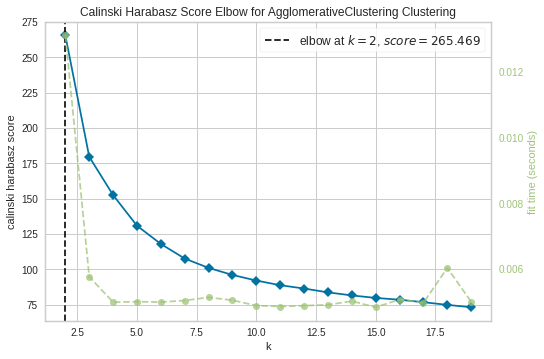

In [ ]:
# Calinski Harabasz Score for Agglomerative Clustering

model = AgglomerativeClustering()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,20),metric='calinski_harabasz', timings= True)
visualizer.fit(trans_data)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

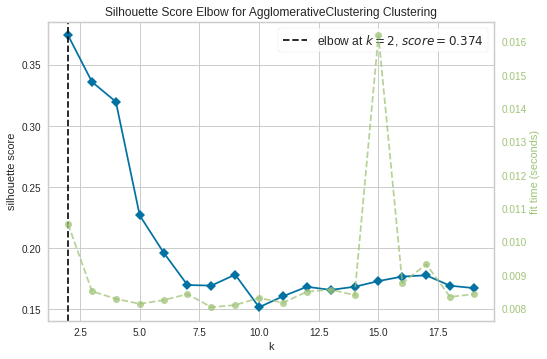

In [ ]:
# Silhouette Score for Agglomerative Clustering

model = AgglomerativeClustering()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,20),metric='silhouette', timings= True)
visualizer.fit(trans_data)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

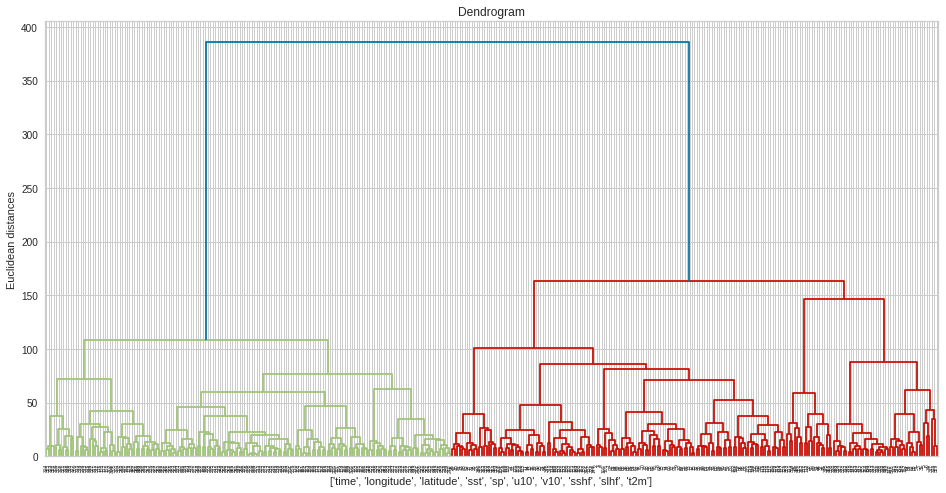

In [ ]:
# graph size
plt.figure(1, figsize = (16 ,8))

# creating the dendrogram
dendrogram = sch.dendrogram(sch.linkage(trans_data, method  = "ward"))

var = list(data.variables)

# ploting graphabs
plt.title('Dendrogram')
plt.xlabel(var)
plt.ylabel('Euclidean distances')
plt.show()

###Implementing Agglomerative Hierarchical clustering

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/ECRP_Data_Science/Implementation and Results/Jianwu_test/PCA_Result_Combination/PCA_Combined_var1.csv")

In [ ]:
df2 = df.time_step
df2

0        2021_0
1        2021_1
2       2021_10
3      2021_100
4      2021_101
         ...   
360     2021_94
361     2021_95
362     2021_96
363     2021_97
364     2021_98
Name: time_step, Length: 365, dtype: object

In [ ]:
# calling the agglomerative algorithm and choosing n_clusters = 4 based on elbow value
model = AgglomerativeClustering(n_clusters = 7, affinity = 'euclidean', linkage ='average')

# training the model on transformed data
y_model = model.fit(trans_data)
labels = y_model.labels_

# creating pandas dataframe on transformed data
df1 = pd.DataFrame(df2, columns=['time_step'])
df1['clusterid'] = labels
#df1["cluster"] = cluster.labels_
df1['clusterid'].value_counts()
df1.to_csv("/content/drive/MyDrive/Private/Image_Similarity/Agglo_Daily_PCA11_Norm.csv")
df1

time_step  clusterid
0      2021_0          4
1      2021_1          4
2     2021_10          4
3    2021_100          4
4    2021_101          4
..        ...        ...
360   2021_94          6
361   2021_95          6
362   2021_96          6
363   2021_97          6
364   2021_98          6

[365 rows x 2 columns]

In [ ]:
df1.groupby('clusterid').count()

time_step
clusterid           
0                  4
1                  5
2                 13
3                167
4                164
5                  2
6                 10

In [ ]:
# # creating pandas dataframe on transformed data
# norm_data = pd.DataFrame(norm_data, columns=['time_step'])
# norm_data['Cluster'] = labels
# #df1["cluster"] = cluster.labels_
# norm_data['Cluster'].value_counts()

In [ ]:
classification = labels
classification

array([4, 4, 4, 4, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       2, 2, 4, 4, 4, 2, 2, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 6, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [ ]:
trans_data['Cluster'] = classification
trans_data

PC_1       PC_2       PC_3       PC_4      PC_5      PC_6      PC_7  \
0    14.322892   5.597010  -5.206832  12.185961 -0.827931 -4.527164  0.701693   
1    14.946676  -1.529004  -2.361471  18.377357  0.187829 -4.077321 -1.745596   
2    15.516234  -8.947399   1.701612  21.752635 -4.862390 -2.274503 -1.094145   
3    16.381521 -10.849598   3.896199  17.910412 -7.842916 -1.184885 -4.861774   
4    16.717359  -6.233022   7.235995  21.983062 -7.474110 -5.329982 -5.206158   
..         ...        ...        ...        ...       ...       ...       ...   
360  10.050502 -20.973653  -2.572095  -1.211986  4.149352  2.398439 -4.862138   
361  10.796356 -25.935865  -5.352422   2.151608  4.051316  2.236251 -0.613757   
362  14.391105 -18.924465   8.941200   2.599492  4.534573  2.370861  2.825248   
363  16.281829 -20.370831  15.464218   6.119504  5.520241  2.664726 -0.933134   
364  16.646688 -14.630541  22.664855  -0.072299  2.301754  3.259306  1.562434   

         PC_8      PC_9     PC_10     PC_11  Cluster  
0    0.908252  1.891758 -0.469721  0.609918        4  
1    3.100452  3.019583  2.237207  2.074107        4  
2    4.251742  2.157962  4.463349  1.556604        4  
3    3.578637 -3.824008  2.281738 -1.110917        4  
4    4.893698 -1.459008  1.196417 -0.100991        4  
..        ...       ...       ...       ...      ...  
360  1.228702  4.588081  0.714266 -1.238248        6  
361  0.826958  6.883928  0.022833 -0.283555        6  
362  3.120387  2.049616 -3.131177  3.030096        6  
363 -0.064049  1.741301 -0.471218  3.745047        6  
364 -1.547208  2.784359  1.693320  3.048996        6  

[365 rows x 12 columns]

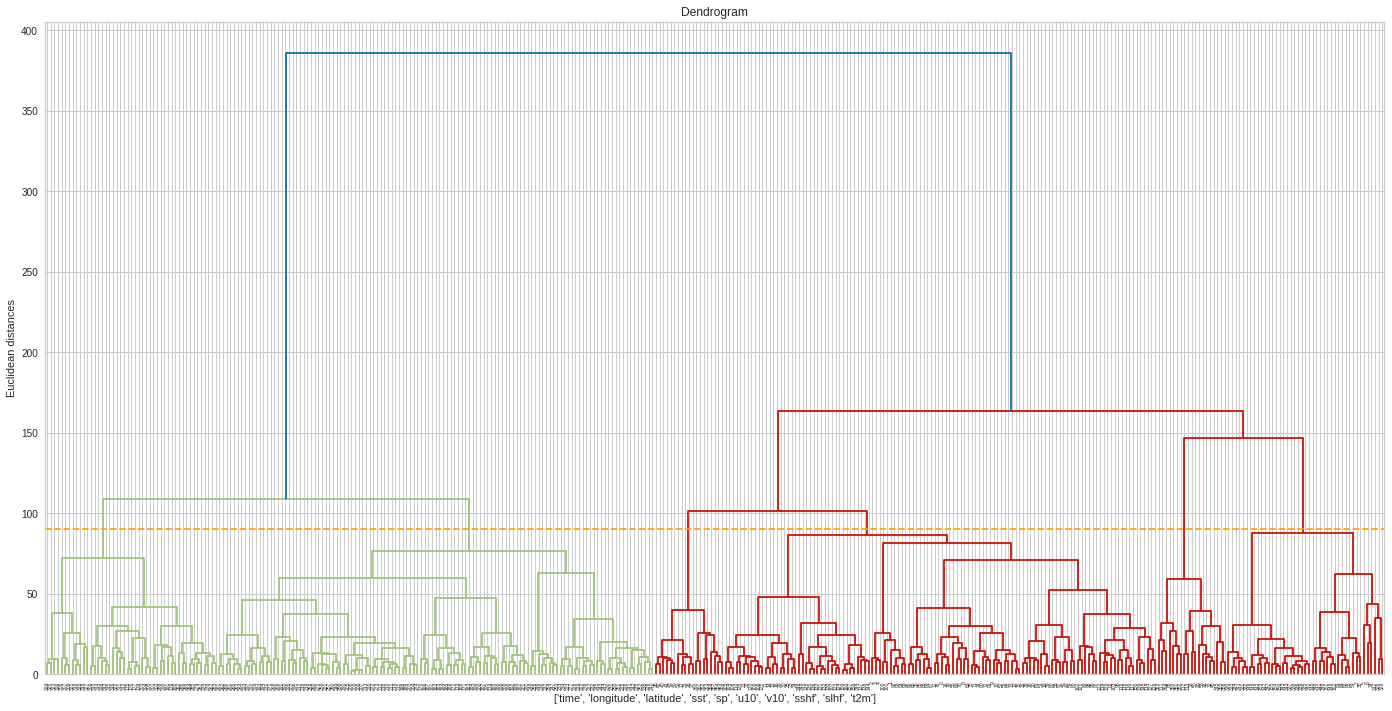

In [ ]:
# graph size
plt.figure(1, figsize = (24 ,12))

# creating the dendrogram
dendrogram = sch.dendrogram(sch.linkage(trans_data, method  = "ward"))

plt.axhline(y = 90, color='orange', linestyle ="--")

var = list(data.variables)

# ploting graphabs
plt.title('Dendrogram')
plt.xlabel(var)
plt.ylabel('Euclidean distances')
plt.show()

#**Evaluation Metrics** 

### Non-normalized functions





In [ ]:
# Function to get center of dataset (compute the mean value of all centroids)

# Non-normalized
# Function that creates a dictionary that holds all the cluster centers
def data_centroid(input,formed_clusters): #classification
  Cluster_Centers = {}
  centers = []
  Center = []
  Clusters = n_nor_get_clusters(input,formed_clusters)
  for i in set(formed_clusters):
    Cluster_Centers['Cluster_Center' + str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
    centers.append(Cluster_Centers['Cluster_Center' + str(i)])

  centers_sum = sum(centers)
  centers = []
  n = len(Cluster_Centers['Cluster_Center' + str(i)])
  Centers_sum = np.sum(sum(sum(centers_sum/n)))
  Center.append(Centers_sum)

  return Center

In [ ]:
# Non-normalized
# Function that creates a dictionary that holds the values of dates in each cluster
def get_datewise_clusters(formed_clusters): # classification
  Dates_Cluster = {}
  for i in set(formed_clusters): # classification
    Dates_Cluster['Dates_Cluster'+str(i)] = trans_data.index[trans_data.Cluster == i].to_list()
  return Dates_Cluster

In [ ]:
# Non-normalized
# Function that creats a dictionary that holds all the clusters
def n_nor_get_clusters(input,formed_clusters): # classification
  com_arr = []
  Clusters = {}
  Dates_Cluster = get_datewise_clusters(formed_clusters)
  for i in set(formed_clusters):
    for j in Dates_Cluster['Dates_Cluster'+str(i)]:
      arr = np.array(input.isel(time=j).to_array()) # input is data
      com_arr.append(arr)
    Clusters['Cluster' + str(i)] = np.array(com_arr)
    com_arr = []
  return Clusters    

In [ ]:
# Non-normalized
# Function that creates a dictionary that holds all the cluster centers
def n_nor_get_cluster_centers(input,formed_clusters): #classification
  Cluster_Centers = {}
  Clusters = n_nor_get_clusters(input,formed_clusters)
  for i in set(formed_clusters):
    Cluster_Centers['Cluster_Center' + str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
  return Cluster_Centers

In [ ]:
# Non-normalized 
#Intra RMSE Calculation Function
def n_nor_intra_rmse(input,formed_clusters):
  sq_diff = []
  intra_rmse = []
  Clusters = n_nor_get_clusters(input,formed_clusters)
  Cluster_Centers = n_nor_get_cluster_centers(input,formed_clusters)

  for i in range(len(Clusters)):
    for j in range(len(Clusters['Cluster' + str(i)])):
      diff = Clusters['Cluster' + str(i)][j] - Cluster_Centers['Cluster_Center' + str(i)]
      Sq_diff = (diff**2)
      sq_diff.append(Sq_diff)
    Sq_diff_sum = sum(sq_diff)
    sq_diff = []
    n = len(Clusters['Cluster' + str(i)])
    Sqrt_diff_sum = np.sqrt(sum(sum(sum(Sq_diff_sum/n))))
    intra_rmse.append(Sqrt_diff_sum)
  return intra_rmse

In [ ]:
# Non-normalized
def handle_missing_values(input):
  var_mean = {}
  for i in input.data_vars:
    if input[i].isnull().sum().item() > 0:
      print(i,'has null values')
      var_mean[str(i) + '_mean'] = input[i].mean().item()
      input[i] = input[i].fillna(var_mean[str(i) + '_mean'])
  return input

### Normalized functions ###

In [ ]:
# Normalized
# Function that creates two dictionaries that hold all the clusters and cluster centers
def nor_get_clusters_and_centers(input,formed_clusters):
  Clusters = {}
  Cluster_Centers = {}
  for i in set(formed_clusters):
    Clusters['Cluster' + str(i)] = np.array(input[input.Cluster == i].drop(columns=['Cluster']))
    Cluster_Centers['Cluster_Center' + str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
  return Clusters,Cluster_Centers

#**RMSE Computation** 

###Intra and Inter RMSE Calculation Function###

In [ ]:
# Normalized

def nor_intra_rmse(input,formed_clusters):
  intra_rmse = []
  sq_diff = []
  Clusters,Cluster_Centers = nor_get_clusters_and_centers(input,formed_clusters)
  for i in range(len(Clusters)):
    for j in range(len(Clusters['Cluster' + str(i)])):
      diff = Clusters['Cluster' + str(i)][j] - Cluster_Centers['Cluster_Center' + str(i)]
      Sq_diff = (diff**2)
      sq_diff.append(Sq_diff)
    Sq_diff_sum = sum(sum(sq_diff))
    sq_diff = []
    n = len(Clusters['Cluster' + str(i)])
    Sqrt_diff_sum = np.sqrt(Sq_diff_sum/n)
    intra_rmse.append(Sqrt_diff_sum)
  return intra_rmse

In [ ]:
# RMSE Calculation
def RMSE(input,formed_clusters,normalize=False):
  inter_rmse = []
  avg_cluster = {}

  if normalize == False:
    input = handle_missing_values(input)
    Clusters = n_nor_get_clusters(input,formed_clusters)
    mat = pd.DataFrame(columns=range(len(Clusters)),index=range(len(Clusters)))
    for i in range(len(Clusters)):
      avg_cluster['avg_cluster'+str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
    for i in range(len(Clusters)):
      for j in range(len(Clusters)):
        if i == j:
          a = n_nor_intra_rmse(input,formed_clusters)
          mat[i].iloc[j] = round(a[i],2)
        else:
          diff = avg_cluster['avg_cluster' + str(i)] - avg_cluster['avg_cluster' + str(j)]
          Sq_diff = (diff**2)
          #Sq_diff_sum = sum(Sq_diff)
          Sq_diff_sum = sum(sum(sum(Sq_diff)))
          #inter_rmse.append(np.sqrt(Sq_diff_sum))
          n = len(avg_cluster['avg_cluster'+str(i)][0])
          Sqrt_diff_sum = np.sqrt(Sq_diff_sum/n)
          mat[i].iloc[j] = round(Sqrt_diff_sum,2)
          #print('Inter RMSE between cluster',i,'and cluster',j,'is:',inter_rmse.pop())
        

  else:
    trans_data = datatransformation(input)

    # Data Normalization
    trans_data = datanormalization(trans_data)

    # Adding class centers and cluster numbers as columns to the dataframe
    trans_data['Cluster'] = formed_clusters

    # Rearranging the columns in the dataframe
    trans_data = trans_data[['Cluster'] + [c for c in trans_data if c not in ['Cluster']]]
  
    Clusters, Cluster_Centers = nor_get_clusters_and_centers(trans_data,formed_clusters)

    # Doing the below step after finding the cluster centers. Otherwise, we'll be calculating mean on date (index) too.
    #trans_data = trans_data.reset_index()

  
    mat = pd.DataFrame(columns=range(len(Clusters)),index=range(len(Clusters)))
    for i in range(len(Clusters)):
      avg_cluster['avg_cluster'+str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
    for i in range(len(Clusters)):
      for j in range(len(Clusters)):
        if i == j:
          a = nor_intra_rmse(trans_data,formed_clusters)
          mat[i].iloc[j] = round(a[i],2)
        else:
          diff = avg_cluster['avg_cluster' + str(i)] - avg_cluster['avg_cluster' + str(j)]
          Sq_diff = (diff**2)
          #Sq_diff_sum = sum(Sq_diff)
          Sq_diff_sum = sum(Sq_diff)
          #inter_rmse.append(np.sqrt(Sq_diff_sum))
          Sqrt_diff_sum = np.sqrt(Sq_diff_sum)
          mat[i].iloc[j] = round(Sqrt_diff_sum,2)
          #print('Inter RMSE between cluster',i,'and cluster',j,'is:',inter_rmse.pop())

  return mat

In [ ]:
final1 = RMSE(data,classification,True)
final1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)


0      1      2      3      4      5      6
0  16.29  32.61  34.23   39.5  33.99   30.8  43.64
1  32.61   15.4  22.39  37.59  27.49  23.06  22.49
2  34.23  22.39  15.75   43.3  28.96   30.7  28.79
3   39.5  37.59   43.3  14.39  28.56  25.55  34.05
4  33.99  27.49  28.96  28.56  16.39  31.29  23.22
5   30.8  23.06   30.7  25.55  31.29  12.28  32.22
6  43.64  22.49  28.79  34.05  23.22  32.22  13.21

In [ ]:
final1.to_csv("/content/drive/MyDrive/Private/Image_Similarity/rmse_daily_final1.csv")

In [ ]:
# df1 = pd.read_csv("/content/drive/MyDrive/Private/Image_Similarity/daily_final1.csv")
# df1

In [ ]:
final2 = RMSE(data,classification,False)
final2

0           1           2           3           4           5  \
0  8887289.04  2794071.22  1637261.92   4240386.3  4605491.16  2413509.56   
1  2794071.22  9671078.25  2271970.27   2582796.5  2917666.25   1282458.4   
2  1637261.92  2271970.27  9531554.29  3529121.29   3844007.8  1667411.73   
3   4240386.3   2582796.5  3529121.29  7656326.27   436568.01  3307239.47   
4  4605491.16  2917666.25   3844007.8   436568.01  8279554.44  3631037.04   
5  2413509.56   1282458.4  1667411.73  3307239.47  3631037.04  8549957.32   
6  3585099.39  1950022.28  2762638.07    945917.5  1229025.23   2513436.3   

            6  
0  3585099.39  
1  1950022.28  
2  2762638.07  
3    945917.5  
4  1229025.23  
5   2513436.3  
6  9084520.04

In [ ]:
final2.to_csv("/content/drive/MyDrive/Private/Image_Similarity/rmse_daily_final2.csv")

In [ ]:
# This is to showcase the scenario where a user does not pass the third parameter
# The default value has been set to False
final3 = RMSE(data,classification)
final3

#**Evaluation - Spatial Correlation Coefficient**

In [ ]:
#For Spatial Correlation coefficient computation
'''
   Input parameters:
         Data: A 4-D xarray
         labels: 1-D array
         Boolean: Offers the user an option to normalize data

   Returns: 
   
   An N X M matrix whose diagonal is a measure of intra-spatial correlation between data points in a cluster
   while the rest of the values represent the inter-spatial correlation between data points in different clusters.
   
'''


def pearson_PM(x, y):

  #convert format from netcdf to np array
    #x_form = x.to_numpy()
    #y_form = y.to_numpy()

    #Flatten/transform from 2d to 1d
    X_flat = x.flatten()
    Y_flat = y.flatten()

    #Compute correlation matrix
    corr_mat = np.corrcoef(X_flat, Y_flat)

    #Return entry [0,1]
    return corr_mat[0,1]

In [ ]:
# # Converting the normalized data array into a pandas dataframe
# trans_data = datatransformation(data)
# nor_data = np.array(datanormalization(trans_data)) # This is just a trial
# trans_data = pd.DataFrame(nor_data, columns=trans_data.columns, index=trans_data.index)
# # Adding class centers and cluster numbers as columns to the dataframe
# #trans_data['Class_Center'] = class_centers
# trans_data['Cluster'] = classification
# # Rearranging the columns in the dataframe
# #trans_data = trans_data[['Class_Center', 'Cluster'] + [c for c in trans_data if c not in ['Class_Center', 'Cluster']]]
# #trans_data1 = trans_data
# #trans_data = trans_data.reset_index()
# trans_data

In [ ]:
#trans_data.to_csv("/content/drive/MyDrive/Private/Image_Similarity/trans_data_daily.csv")

In [ ]:
#trans_data = pd.read_csv("/content/drive/MyDrive/Private/Image_Similarity/daily_trans_norm.csv")

In [ ]:
#trans_data = trans_data.iloc[:,1:]

In [ ]:
#trans_data['Cluster'] = classification
#trans_data

In [ ]:
#Intra-spatial correlation coefficient Calculation Function
import functools 

def n_nor_intra_sp_corr(input,formed_clusters):
  mylist = []
  intra_sp_corr = []
  Clusters = n_nor_get_clusters(input,formed_clusters)
  Cluster_Centers = n_nor_get_cluster_centers(input,formed_clusters)
  
  for i in range(len(Clusters)):
    mylist = []
    for j in range(len(Clusters['Cluster' + str(i)])):
      corr_coeff = pearson_PM(Clusters['Cluster' + str(i)][j], Cluster_Centers['Cluster_Center' + str(i)])
       #print('i: {}, j: {}, corr_coeff:{}'.format(i, j, corr_coeff))
      mylist.append(corr_coeff)
      average_corr_coeff = sum(mylist) / len(mylist)
    intra_sp_corr.append(average_corr_coeff)
  return intra_sp_corr

In [ ]:
#Intra-spatial correlation coefficient Calculation Function
import functools 

def sp_corr(input,formed_clusters):
  avg_cluster = {}
  Clusters = n_nor_get_clusters(input,formed_clusters)
  mat = pd.DataFrame(columns=range(len(Clusters)),index=range(len(Clusters)))
  for i in range(len(Clusters)):
    avg_cluster['avg_cluster'+str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
  for i in range(len(Clusters)):
    for j in range(len(Clusters)):
      if i == j:
        a = n_nor_intra_sp_corr(input,formed_clusters)
        mat[i].iloc[j] = round(a[i],2)
      else:
        corr_coeff = pearson_PM(avg_cluster['avg_cluster' + str(i)], avg_cluster['avg_cluster' + str(j)])
        mat[i].iloc[j] = corr_coeff
          #print('Inter RMSE between cluster',i,'and cluster',j,'is:',inter_rmse.pop())
    return mat

##Normalized - Spatial Correlation##

In [ ]:
#Intra-spatial correlation coefficient Calculation Function

def nor_intra_sp_corr(input,formed_clusters):
  mylist = []
  intra_sp_corr = []
  Clusters,Cluster_Centers = nor_get_clusters_and_centers(input,formed_clusters)
  
  for i in range(len(Clusters)):
    mylist = []
    for j in range(len(Clusters['Cluster' + str(i)])):
      corr_coeff = pearson_PM(Clusters['Cluster' + str(i)][j], Cluster_Centers['Cluster_Center' + str(i)])
       #print('i: {}, j: {}, corr_coeff:{}'.format(i, j, corr_coeff))
      mylist.append(corr_coeff)
      average_corr_coeff = sum(mylist) / len(mylist)
    intra_sp_corr.append(average_corr_coeff)
  return intra_sp_corr

In [ ]:
# Non-normalized Spatial Correlation Calculation
def sp_corr(input,formed_clusters,normalize=False):
  inter_sp_corr = []
  avg_cluster = {}

  if normalize == False:
    input = handle_missing_values(input)
    Clusters = n_nor_get_clusters(input,formed_clusters)
    mat = pd.DataFrame(columns=range(len(Clusters)),index=range(len(Clusters)))
    for i in range(len(Clusters)):
      avg_cluster['avg_cluster'+str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
    for i in range(len(Clusters)):
      for j in range(len(Clusters)):
        if i == j:
          a = n_nor_intra_sp_corr(input,formed_clusters)
          mat[i].iloc[j] = round(a[i],2)
        else:
          corr_coeff = pearson_PM(avg_cluster['avg_cluster' + str(i)], avg_cluster['avg_cluster' + str(j)])
          mat[i].iloc[j] = corr_coeff
          #print('Inter RMSE between cluster',i,'and cluster',j,'is:',inter_rmse.pop())
        

  else:
    trans_data = datatransformation(input)

    # Data Normalization
    trans_data = datanormalization(trans_data)

    # Adding class centers and cluster numbers as columns to the dataframe
    trans_data['Cluster'] = formed_clusters

    # Rearranging the columns in the dataframe
    trans_data = trans_data[['Cluster'] + [c for c in trans_data if c not in ['Cluster']]]
  
    Clusters, Cluster_Centers = nor_get_clusters_and_centers(trans_data,formed_clusters)

    #Doing the below step after finding the cluster centers. Otherwise, we'll be calculating mean on date (index) too.
    #trans_data = trans_data.reset_index()

  
    mat = pd.DataFrame(columns=range(len(Clusters)),index=range(len(Clusters)))
    for i in range(len(Clusters)):
      avg_cluster['avg_cluster'+str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
    for i in range(len(Clusters)):
      for j in range(len(Clusters)):
        if i == j:
          a = n_nor_intra_sp_corr(input,formed_clusters)
          mat[i].iloc[j] = round(a[i],2)
        else:
          corr_coeff = pearson_PM(avg_cluster['avg_cluster' + str(i)], avg_cluster['avg_cluster' + str(j)])
          mat[i].iloc[j] = corr_coeff
          #print('Inter RMSE between cluster',i,'and cluster',j,'is:',inter_rmse.pop())
        

  return mat

In [ ]:
sp_final1 = sp_corr(data, classification, True)
sp_final1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)


0         1         2         3         4         5         6
0      0.98 -0.477374  -0.27526  0.205019  0.122738 -0.104336 -0.583738
1 -0.477374      0.96  0.472337 -0.397089  0.315501   0.29172  0.697831
2  -0.27526  0.472337      0.97  -0.49979  0.463286  0.049745  0.518301
3  0.205019 -0.397089  -0.49979      0.93 -0.186296  0.183893 -0.403644
4  0.122738  0.315501  0.463286 -0.186296       0.9 -0.372248  0.481808
5 -0.104336   0.29172  0.049745  0.183893 -0.372248      0.99 -0.185699
6 -0.583738  0.697831  0.518301 -0.403644  0.481808 -0.185699      0.95

In [ ]:
sp_final1.to_csv("/content/drive/MyDrive/Private/Image_Similarity/Hierach_daily_final1.csv")

In [ ]:
#sp_final2 = sp_corr(data, classification, False)
#sp_final2

In [ ]:
#sp_final2.to_csv("/content/drive/MyDrive/Private/Image_Similarity/Hier_daily_final2.csv")

#**Evaluation - Silhouette Coefficient**

In [ ]:
def silhouette_score1(X, labels, pass_trans_data = True, *, metric="euclidean", sample_size=None, random_state=None, **kwds):
   if pass_trans_data == True:
          k = list(locals().values()) # k will be the list which holds the values of the parameters that are being passed to the function
          #path = str(k[0]) # path will hold the first parameter's value
          #fullpath = os.path.join("/content/drive/MyDrive/Private/Image_Similarity/Transformed_data/" + path + ".csv")
          

          path = ("/content/drive/MyDrive/Private/Image_Similarity/daily_trans_norm.csv")
          #X1 = pd.read_csv(fullpath, index_col=[0]) # saved transformed dataframe will be read
          X1 = pd.read_csv(path, index_col=[0])
          X1 = datanormalization(X1) # the data will be normalized

          if sample_size is not None:
            X1, labels = check_X_y(X1, labels, accept_sparse=["csc", "csr"])
            random_state = check_random_state(random_state)
            indices = random_state.permutation(X1.shape[0])[:sample_size]
            if metric == "precomputed":
              X1, labels = X1[indices].T[indices].T, labels[indices]
            else:
              X1, labels = X1[indices], labels[indices]
          return np.mean(silhouette_samples(X1, labels, metric=metric, **kwds))
   
   else:
     X1 = data[X]
     X1 = datatransformation(X)
     X1 = datanormalization(X1)   
     if sample_size is not None:
        X1, labels = check_X_y(X1, labels, accept_sparse=["csc", "csr"])
        random_state = check_random_state(random_state)
        indices = random_state.permutation(X1.shape[0])[:sample_size]
        if metric == "precomputed":
            X1, labels = X1[indices].T[indices].T, labels[indices]
        else:
            X1, labels = X1[indices], labels[indices]
     return np.mean(silhouette_samples(X1, labels, metric=metric, **kwds))

In [ ]:
silhouette_Coefficient = silhouette_score1('data', classification)
print("The average silhouette_score is :", silhouette_Coefficient)

The average silhouette_score is : 0.2605872672037418


#**Calinski-Harabasz Calculation Function**#

In [ ]:
n_nor_get_cluster_centers(data,classification)

{'Cluster_Center0': array([[[ 2.94625166e+02,  2.94716438e+02,  2.94679606e+02, ...,
           2.90809177e+02,  2.90762663e+02,  2.90640377e+02],
         [ 2.94478326e+02,  2.94595485e+02,  2.94605653e+02, ...,
           2.90612438e+02,  2.90690962e+02,  2.90638323e+02],
         [ 2.94258440e+02,  2.94280411e+02,  2.94289922e+02, ...,
           2.90463095e+02,  2.90509422e+02,  2.90532661e+02],
         ...,
         [ 2.93962015e+02,  2.93875106e+02,  2.93811040e+02, ...,
           2.89907726e+02,  2.89822293e+02,  2.89726003e+02],
         [ 2.93912327e+02,  2.93819487e+02,  2.93714697e+02, ...,
           2.89873664e+02,  2.89865070e+02,  2.89754796e+02],
         [ 2.93868856e+02,  2.93756135e+02,  2.93608285e+02, ...,
           2.89847259e+02,  2.89759542e+02,  2.89644947e+02]],
 
        [[ 1.01291383e+05,  1.01305155e+05,  1.01324935e+05, ...,
           1.02864954e+05,  1.02908226e+05,  1.02950763e+05],
         [ 1.01279008e+05,  1.01301101e+05,  1.01314927e+05, ...,
  

In [ ]:
# Non-normalized
# Function that creates a dictionary that holds all the cluster centers
def data_centroid(input,formed_clusters): #classification
  Cluster_Centers = {}
  centers = []
  Center = []
  Clusters = n_nor_get_clusters(input,formed_clusters)
  for i in set(formed_clusters):
    Cluster_Centers['Cluster_Center' + str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
    centers.append(Cluster_Centers['Cluster_Center' + str(i)])

  centers_sum = sum(centers)
  centers = []
  n = len(Cluster_Centers['Cluster_Center' + str(i)])
  #Centers_sum = np.sum(sum(sum(centers_sum/n)))
  Centers_sum = centers_sum/n
  Center.append(Centers_sum)

  return Center

In [ ]:
data_center = data_centroid(data, classification)
data_center

[array([[[ 2.94813805e+02,  2.94718755e+02,  2.94571231e+02, ...,
           2.90556406e+02,  2.90465657e+02,  2.90366948e+02],
         [ 2.94799020e+02,  2.94694431e+02,  2.94529631e+02, ...,
           2.90519483e+02,  2.90473139e+02,  2.90371386e+02],
         [ 2.94734431e+02,  2.94609314e+02,  2.94445880e+02, ...,
           2.90475791e+02,  2.90428802e+02,  2.90354224e+02],
         ...,
         [ 2.94232437e+02,  2.94196016e+02,  2.94132853e+02, ...,
           2.90049796e+02,  2.89952974e+02,  2.89847815e+02],
         [ 2.94181563e+02,  2.94151002e+02,  2.94089761e+02, ...,
           2.90066421e+02,  2.89969412e+02,  2.89850638e+02],
         [ 2.94134318e+02,  2.94090477e+02,  2.94028188e+02, ...,
           2.90077622e+02,  2.89948214e+02,  2.89773108e+02]],
 
        [[ 1.01752517e+05,  1.01741884e+05,  1.01734495e+05, ...,
           1.01344660e+05,  1.01335721e+05,  1.01326124e+05],
         [ 1.01741377e+05,  1.01738241e+05,  1.01723693e+05, ...,
           1.01344998

#**Intra and Inter Calinski-Harabasz Calculation Function**#
[link text](https://python-bloggers.com/2022/03/calinski-harabasz-index-for-k-means-clustering-evaluation-using-python/)

In [ ]:
# Non-normalized 
#Intra Calculation Function
def n_nor_intra_CH(input,formed_clusters):
  sq_diff = []
  intra_CH = []
  Clusters = n_nor_get_clusters(input,formed_clusters)
  Cluster_Centers = n_nor_get_cluster_centers(input,formed_clusters)

  for i in range(len(Clusters)):
    for j in range(len(Clusters['Cluster' + str(i)])):
      diff = Clusters['Cluster' + str(i)][j] - Cluster_Centers['Cluster_Center' + str(i)]
      Sq_diff = (diff**2)
      sq_diff.append(Sq_diff)
    Sq_diff_sum = sum(sq_diff)
    sq_diff = []
    n = len(Clusters['Cluster' + str(i)])
    Sum_diff = np.sum(sum(sum(Sq_diff_sum/n)))
    intra_CH.append(Sum_diff)
  return intra_CH

In [ ]:
n_nor_intra_CH(data,classification)

[78983906511170.69,
 93529754441098.16,
 90850527172356.73,
 58619332014785.2,
 68551021721979.81,
 73101770237968.16,
 82528504384998.95]

### Normalized functions ###

In [ ]:
# Normalized
# Function that creates two dictionaries that hold all the clusters and cluster centers
def nor_get_clusters_and_centers(input,formed_clusters):
  Clusters = {}
  Cluster_Centers = {}
  for i in set(formed_clusters):
    Clusters['Cluster' + str(i)] = np.array(input[input.Cluster == i].drop(columns=['Cluster']))
    Cluster_Centers['Cluster_Center' + str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
  return Clusters,Cluster_Centers

In [ ]:
# Normalized

def nor_intra_CH(input,formed_clusters):
  intra_CH = []
  sq_diff = []
  Clusters = n_nor_get_clusters(input,formed_clusters)
  Cluster_Centers = n_nor_get_cluster_centers(input,formed_clusters)
  #Clusters,Cluster_Centers = nor_get_clusters_and_centers(input,formed_clusters)
  for i in range(len(Clusters)):
    for j in range(len(Clusters['Cluster' + str(i)])):
      diff = Clusters['Cluster' + str(i)][j] - Cluster_Centers['Cluster_Center' + str(i)]
      Sq_diff = (diff**2)
      sq_diff.append(Sq_diff)
    Sq_diff_sum = sum(sum(sq_diff))
    sq_diff = []
    n = len(Clusters['Cluster' + str(i)])
    Sum_diff = np.sum(sum(sum(Sq_diff_sum/n)))
    intra_CH.append(Sum_diff)
  return intra_CH

In [ ]:
nor_intra_CH(data,classification)

[78983906511170.7,
 93529754441098.16,
 90850527172356.73,
 58619332014785.2,
 68551021721979.82,
 73101770237968.16,
 82528504384998.95]

In [ ]:
def nor_inter_CH(input,formed_clusters):
  inter_CH = []
  sq_diffs = []
  Cluster_Centers = n_nor_get_cluster_centers(input,formed_clusters)
  #Clusters,Cluster_Centers = nor_get_clusters_and_centers(input,formed_clusters)
  for i in range(len(Cluster_Centers )):
    diff = Cluster_Centers['Cluster_Center' + str(i)] - data_center
                           
    Sq_diff = (diff**2)
    sq_diffs.append(Sq_diff)
    Sq_diff_sum = sum(sq_diffs)
    sq_diffs = []
    n = len(Cluster_Centers['Cluster_Center' + str(i)] )
    Sum_diff = np.sum(sum(sum(Sq_diff_sum/n)))
    inter_CH.append(Sum_diff)
  return inter_CH

In [ ]:
nor_inter_CH(data,classification)

[37494004549226.57,
 8411392604725.445,
 18357169367310.516,
 21405892340610.438,
 29987150875974.85,
 14343867806524.371,
 7918334271137.14]

In [ ]:
# # Calinski_Harabasz Calculation
# def Calinski_Harabasz(input,formed_clusters,normalize=False):
#   inter_CH = []
#   avg_cluster = {}

#   if normalize == False:
#     input = handle_missing_values(input)
#     Clusters = n_nor_get_clusters(input,formed_clusters)
#     mat = pd.DataFrame(columns=range(len(Clusters)),index=range(len(Clusters)))
#     for i in range(len(Clusters)):
#       avg_cluster['avg_cluster'+str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
#     for i in range(len(Clusters)):
#       for j in range(len(Clusters)):
#         if i == j:
#           a = n_nor_intra_CH(input,formed_clusters)
#           mat[i].iloc[j] = round(a[i],2)
#         else:
#             b = nor_inter_CH(input,formed_clusters)
#             mat[i].iloc[j] = round(b[i],2)
        

#   else:
#     trans_data = datatransformation(input)

#     # Data Normalization
#     trans_data = datanormalization(trans_data)

#     # Adding class centers and cluster numbers as columns to the dataframe
#     trans_data['Cluster'] = formed_clusters

#     # Rearranging the columns in the dataframe
#     trans_data = trans_data[['Cluster'] + [c for c in trans_data if c not in ['Cluster']]]
  
#     Clusters, Cluster_Centers = nor_get_clusters_and_centers(trans_data,formed_clusters)

#     # Doing the below step after finding the cluster centers. Otherwise, we'll be calculating mean on date (index) too.
#     #trans_data = trans_data.reset_index()

  
#     mat = pd.DataFrame(columns=range(len(Clusters)),index=range(len(Clusters)))
#     for i in range(len(Clusters)):
#       avg_cluster['avg_cluster'+str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
#     for i in range(len(Clusters)):
#       for j in range(len(Clusters)):
#         if i == j:
#           a = n_nor_intra_CH(input,formed_clusters)
#           mat[i].iloc[j] = round(a[i],2)
#         else:
#             b = nor_inter_CH(input,formed_clusters)
#             mat[i].iloc[j] = round(b[i],2)

#   return mat

In [ ]:
def Calinski_Harabasz(input,formed_clusters):
  inter_CH = []
  avg_cluster = {}
  
  input = handle_missing_values(input)
  Clusters = n_nor_get_clusters(input,formed_clusters)
  mat = pd.DataFrame(columns=range(len(Clusters)),index=range(len(Clusters)))
  for i in range(len(Clusters)):
    avg_cluster['avg_cluster'+str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
  for i in range(len(Clusters)):
    for j in range(len(Clusters)):
      if i == j:
        a = n_nor_intra_CH(input,formed_clusters)
        mat[i].iloc[j] = round(a[i],2)
      else:
          b = nor_inter_CH(input,formed_clusters)
          mat[i].iloc[j] = round(b[i],2)
  return mat

In [ ]:
final = Calinski_Harabasz(data,classification)
final

0                     1                      2  \
0    78983906511170.6875   8411392604725.44043  18357169367310.519531   
1  37494004549226.570312  93529754441098.15625  18357169367310.519531   
2  37494004549226.570312   8411392604725.44043  90850527172356.734375   
3  37494004549226.570312   8411392604725.44043  18357169367310.519531   
4  37494004549226.570312   8411392604725.44043  18357169367310.519531   
5  37494004549226.570312   8411392604725.44043  18357169367310.519531   
6  37494004549226.570312   8411392604725.44043  18357169367310.519531   

                       3                      4                      5  \
0  21405892340610.441406  29987150875974.851562  14343867806524.369141   
1  21405892340610.441406  29987150875974.851562  14343867806524.369141   
2  21405892340610.441406  29987150875974.851562  14343867806524.369141   
3  58619332014785.203125  29987150875974.851562  14343867806524.369141   
4  21405892340610.441406    68551021721979.8125  14343867806524.369141   
5  21405892340610.441406  29987150875974.851562   73101770237968.15625   
6  21405892340610.441406  29987150875974.851562  14343867806524.369141   

                       6  
0   7918334271137.139648  
1   7918334271137.139648  
2   7918334271137.139648  
3   7918334271137.139648  
4   7918334271137.139648  
5   7918334271137.139648  
6  82528504384998.953125

#Visualizations

  **Map Visualization with original 2-dimensional dataset**

In [ ]:
## read the timestep and it's cluster ID from your clustering results
def read_combined_cluster(csvlink,varid):
    with open(csvlink, mode ='r')as file:
       # reading the CSV file
       csvFile = pd.read_csv(file)
       if(len(varid)>0):    
          id = csvFile['clusterid']
          time_step = csvFile['time_step']
          days = np.zeros(len(id))-999 
 
          for i in range(len(id)):   
              days[i] = int(time_step[i][5:])
                            
                            
    return days,id

In [ ]:
##called by plot_map to plot the coastline on the map
def plotcoastline(color='k'):
    lon_c = []
    lat_c = []
    # with open('coast.txt') as f:
    with open('/content/drive/MyDrive/ECRP_Data_Science/Implementation and Results/Jianwu_test/visualizations/coast.txt') as f:
        for line in f:
            data = line.split()
            lon_c.append(float(data[0])-360)
            lat_c.append(float(data[1]))
    plt.plot(lon_c,lat_c,color=color)
    return [lon_c,lat_c]

In [ ]:
# plot the map of orignal data (mean value and standard deviation) for each cluster on the specified subpanel
def plot_map(var, var_range,lon0,lat0,fig,panel,cmap0,colorbar,title,ifcontourf):
  ax=plt.subplot(panel)
  if(ifcontourf):  
     p1=plt.contourf(lon0,lat0,var,cmap=cmap0,levels=np.arange(var_range[0],var_range[1],(var_range[1]-var_range[0])/31),extend = 'both') 
     p1.ax.tick_params(labelsize=12)
     plotcoastline(color='k',)
     plt.xlim([min(lon0),max(lon0)])  
     plt.ylim([min(lat0),max(lat0)])    
     plt.title(title,loc='left')   
     plt.xlabel('Longitude')
     plt.ylabel('Latitude')
     if(colorbar):
        ticks = np.linspace(var_range[0], var_range[1], 8, endpoint=True)
        cax = ax.inset_axes([1.04, 0, 0.02, 1], transform=ax.transAxes)
        cb2 = fig.colorbar(p1,orientation='vertical',ax=ax,cax=cax,ticks=ticks)
        cb2.ax.tick_params(labelsize=9)
        
  else:
     p1=ax.contour(lon0,lat0,var,cmap=cmap0,levels=np.arange(var_range[0],var_range[1],(var_range[1]-var_range[0])/11),extend = 'both',linewidth=0.6) 
     p1.ax.tick_params(labelsize=12)
     plt.title(title,loc='right')
     if(colorbar):
        ticks = np.linspace(var_range[0], var_range[1], 12, endpoint=True)
        cax = ax.inset_axes([1.23, 0, 0.02, 1], transform=ax.transAxes)
        cb2 = fig.colorbar(p1,orientation='vertical',ax=ax,cax=cax,ticks=ticks)
        cb2.ax.tick_params(labelsize=9)
  ax.set_aspect(0.65)      

        #cbar = fig.colorbar(p1)
  return [p1]

**Specify the location and file name of the raw dataset**

In [ ]:
# input_dir = './'
# fig_dir = './'
# data_file = '/content/drive/MyDrive/Multivariate Data Independent Study/ERA5_meteo_sfc_2021_daily.nc'

input_dir = '/content/drive/MyDrive/Private/Image_Similarity'
fig_dir = '/content/drive/MyDrive/Data/new_ERA5_meteo_sfc_2021_daily.nc'
year_str='2021'
data_file = '/new_ERA5_meteo_sfc_'+year_str+'_daily.nc'

fcase = input_dir+data_file
##Read time, lat and lon for visualization
fin = Dataset(fcase, "r")
time = np.squeeze(fin['time'][:])
lat0 = np.squeeze(fin['latitude'][:])
lon0 = np.squeeze(fin['longitude'][:])

**Specify the variable name and it's unit coefficient here**

In [ ]:
varids=['sst','slhf','u10','v10','sshf','sp']
ccoefs=[1,-1./3600,1,1,-1./3600,1e-2]

**Read the cluster ID assiged to each time step from the clustering results. You might need to modify this cell to fit your csv format**

In [ ]:
import pandas as pd
# cluster_filename='Kmeans'
# #cluster_filename='PCA_Combined_Norm_Clusters_5'
# cluster_link = cluster_filename+'.csv'

cluster_filename="Agglo_Daily_PCA11_Norm"
cluster_link = input_dir+'/cluster/'+cluster_filename+'.csv'

[days,id]=read_combined_cluster(cluster_link,'OK')


[days,id]=read_combined_cluster(cluster_link,'OK') 
n_cluster = max(id)-min(id)+1
width = 0.3
height = 0.5
panels=[(0.06, 0.08,width, height), (0.39, 0.08,width, height),(0.72, 0.08,width, height),
        (0.06, 0.38, width, height), (0.39, 0.38, width, height),(0.72, 0.38, width, height),
        (0.06, 0.68, width, height),(0.39, 0.68, width, height), (0.72, 0.68, width, height),
]
panels=[(0.06, 0.08,width, height), (0.5, 0.08,width, height),(0.05, 0.5,0.9, 0.3),]


n_cluster = max(id)-min(id)+1
print('total clusters: ',n_cluster)

total clusters:  7


In [ ]:
days


array([  0.,   1.,  10., 100., 101., 102., 103., 104., 105., 106., 107.,
       108., 109.,  11., 110., 111., 112., 113., 114., 114., 115., 116.,
       117., 118., 119.,  12., 120., 121., 122., 123., 124., 125., 126.,
       127., 128., 129.,  13., 130., 131., 132., 133., 134., 135., 136.,
       137., 138., 139.,  14., 140., 141., 142., 143., 144., 145., 146.,
       147., 148., 149.,  15., 150., 151., 152., 153., 154., 155., 156.,
       157., 158., 159.,  16., 160., 161., 162., 163., 164., 165., 166.,
       167., 168., 169.,  17., 170., 171., 172., 173., 174., 175., 176.,
       177., 178., 179.,  18., 180., 181., 182., 183., 184., 185., 186.,
       187., 188., 189.,  19., 190., 191., 192., 193., 194., 195., 196.,
       197., 198., 199.,   2.,  20., 200., 201., 202., 203., 204., 205.,
       206., 207., 208., 209.,  21., 210., 211., 212., 213., 214., 215.,
       216., 217., 218., 219.,  22., 220., 221., 222., 223., 224., 225.,
       226., 227., 228., 229.,  23., 230., 231., 23

**Specify the total subpanels for the visualized clusters. 4 rows x 2 columns for now:**

In [ ]:
panels=np.arange(421,428,dtype=int) #4 rows 2 columns depending on clusters (how much panels you want?)
#You can choose different colormaps
cmap0='coolwarm'

**Start plotting each individual variables: **

varid: sst
var_range: [286.9919318332959, 299.0668423730597]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: The following kwargs were not used by contour: 'linewidth'


varid: slhf
var_range: [1.7836744843812191, 484.54307508757614]
varid: u10
var_range: [-15.129702662479593, 16.82725476413482]
varid: v10
var_range: [-14.294945017569995, 14.039669939743764]
varid: sshf
var_range: [-43.41541985801895, 175.22246693947238]
varid: sp
var_range: [985.3787786916515, 1035.1150602330122]


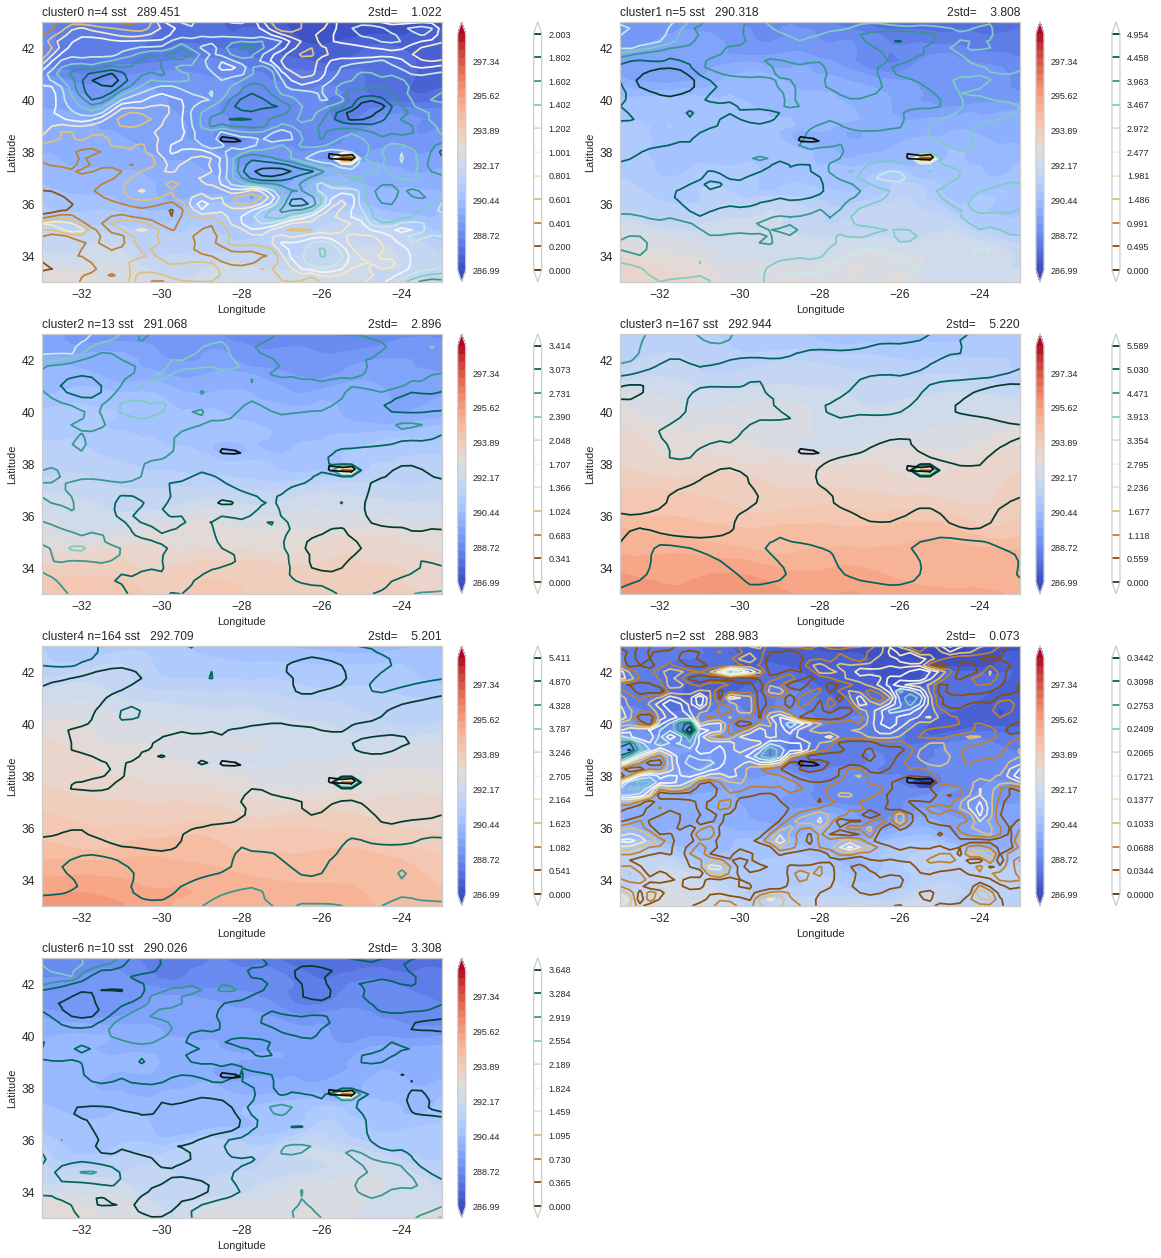

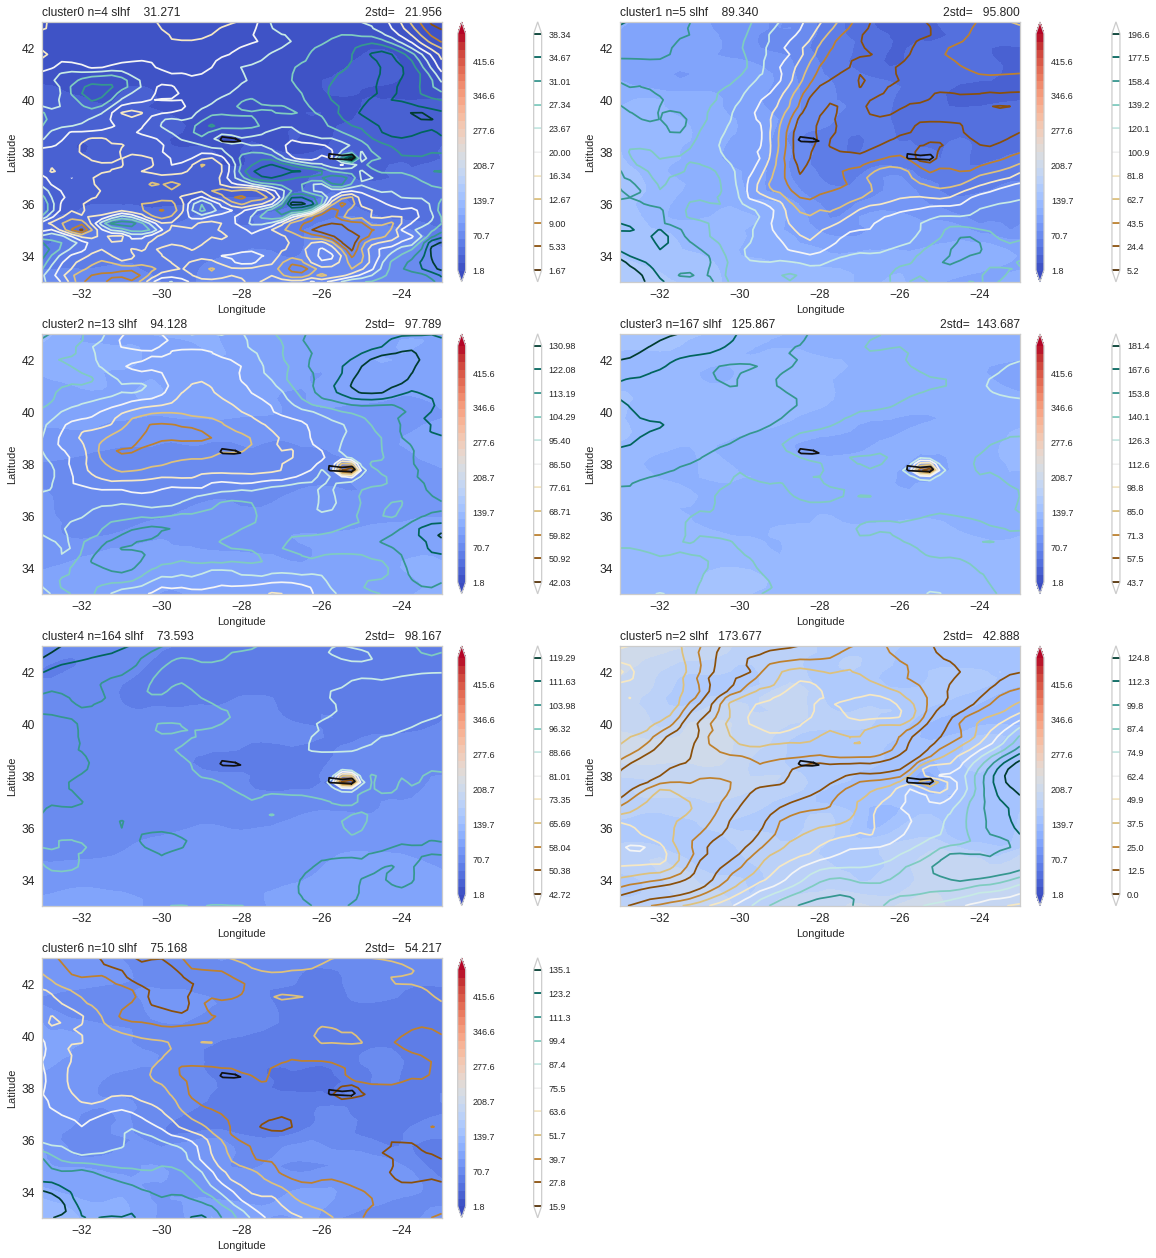

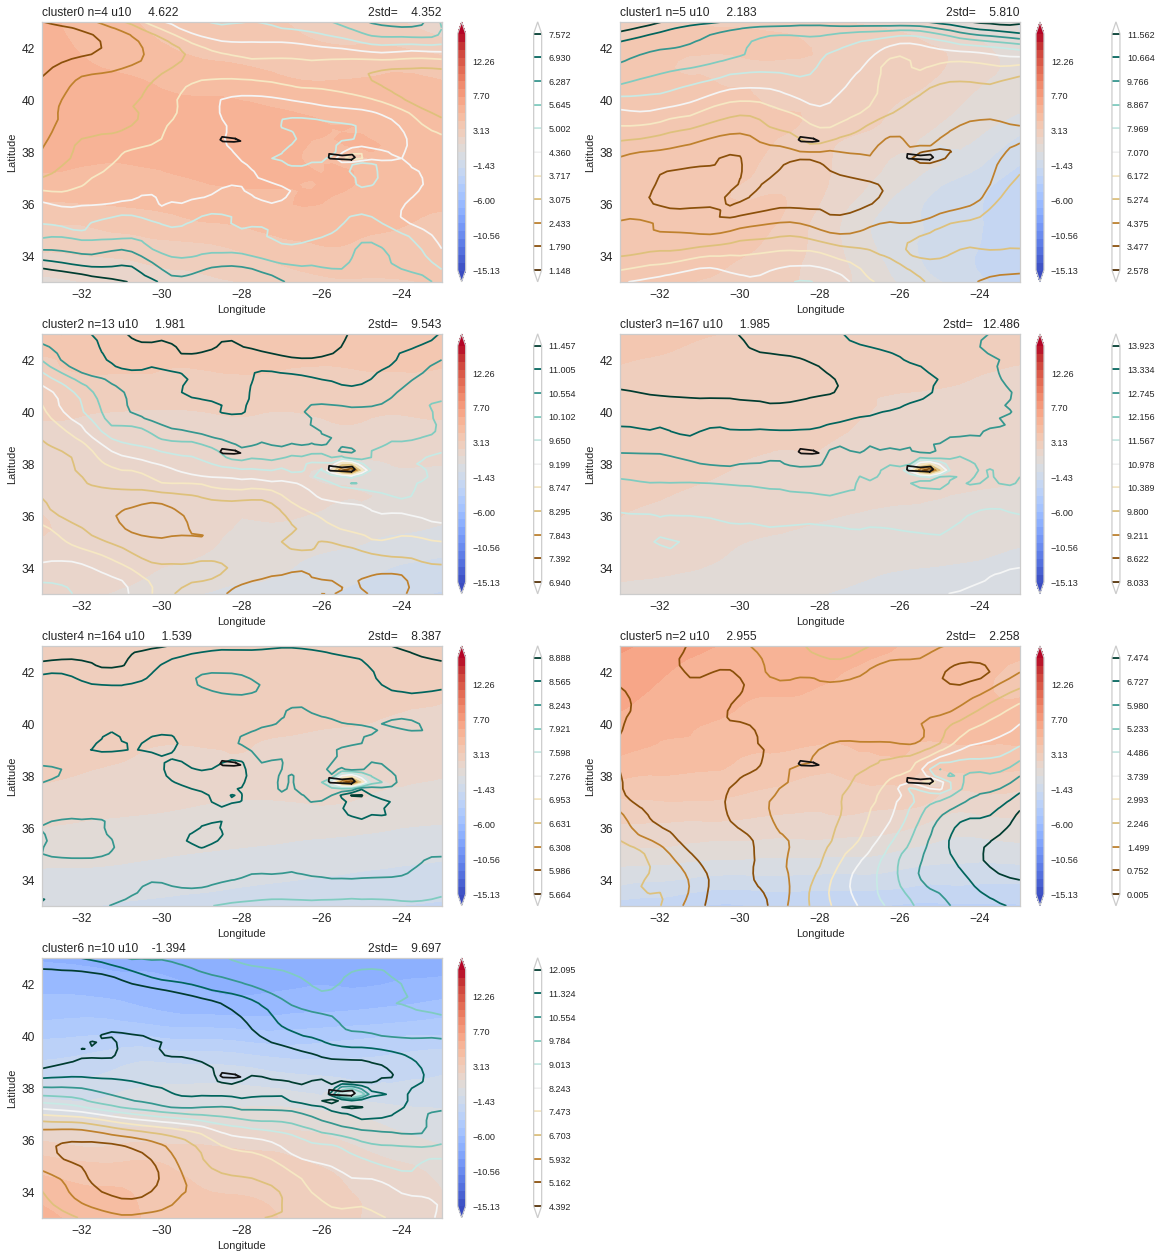

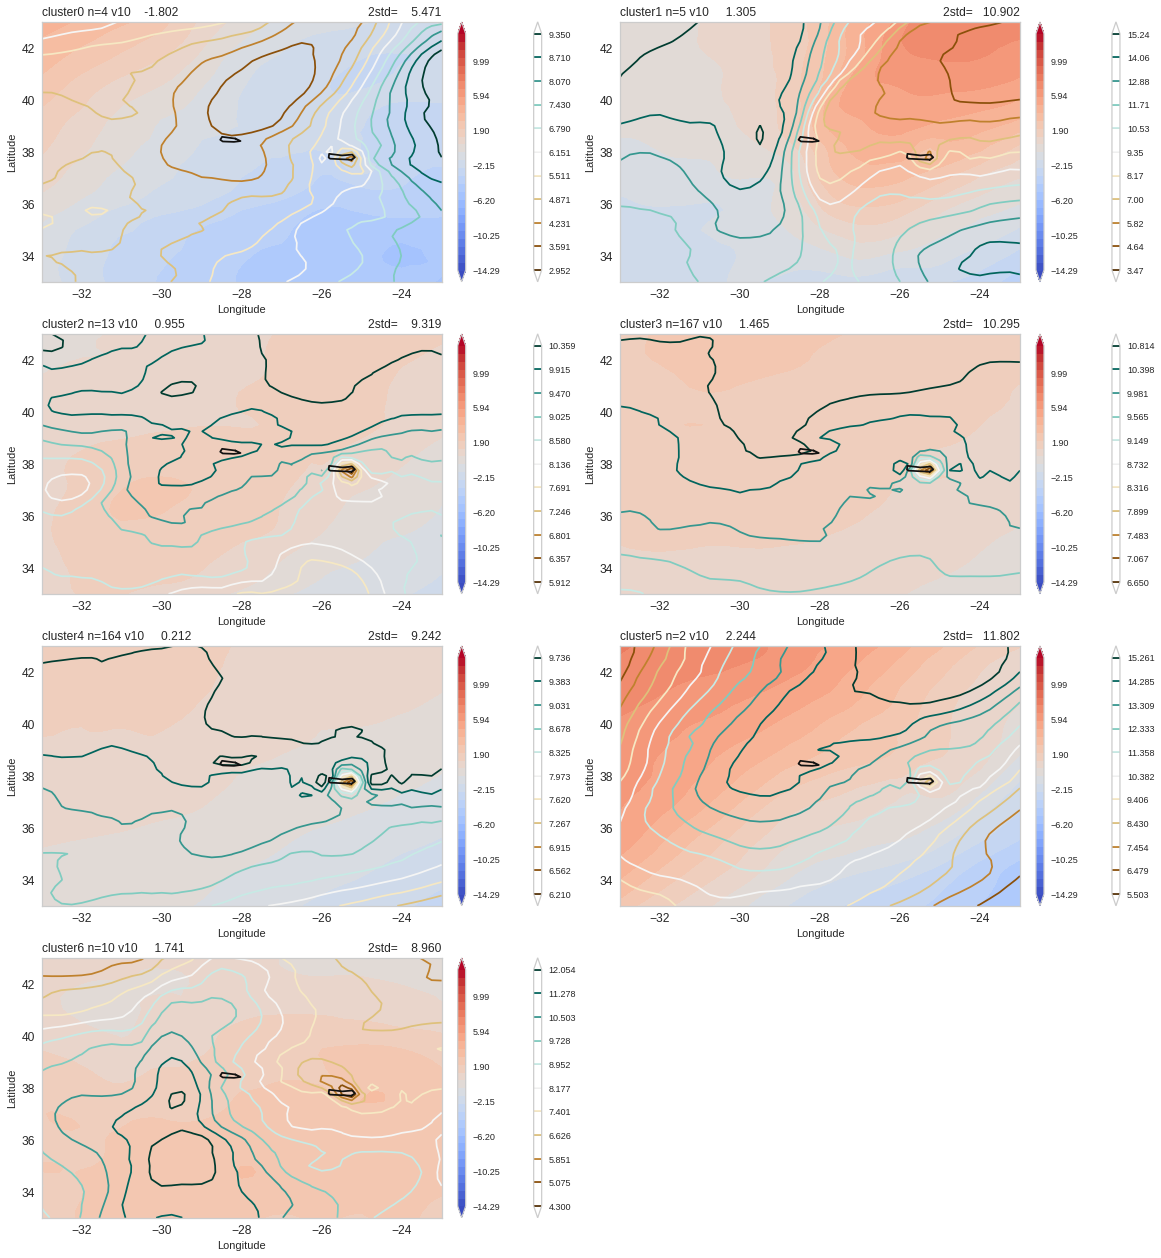

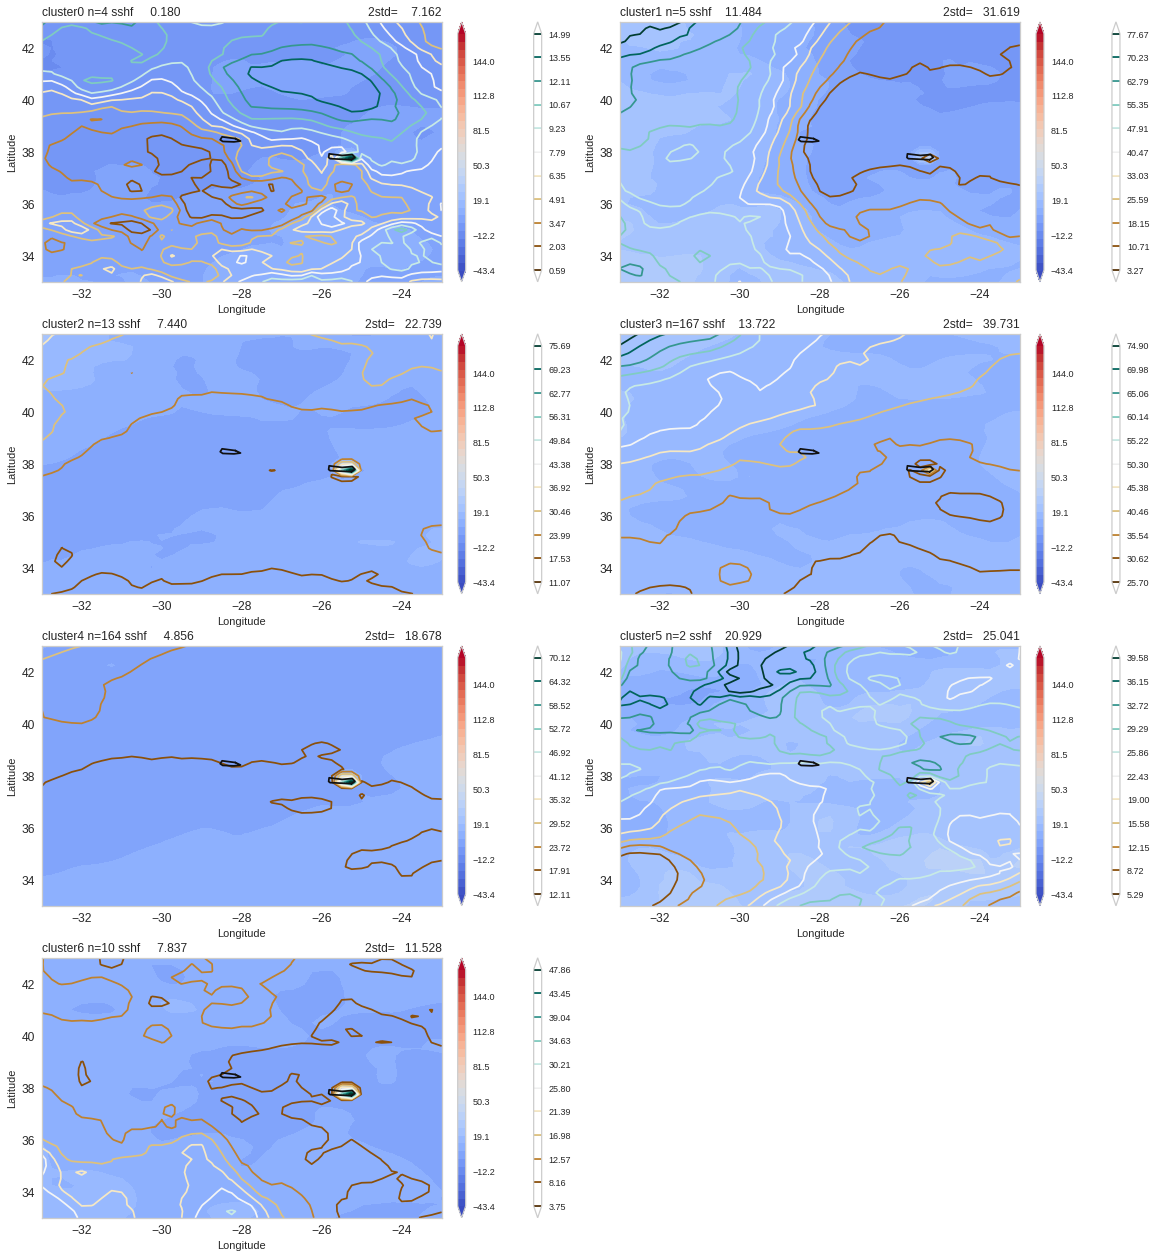

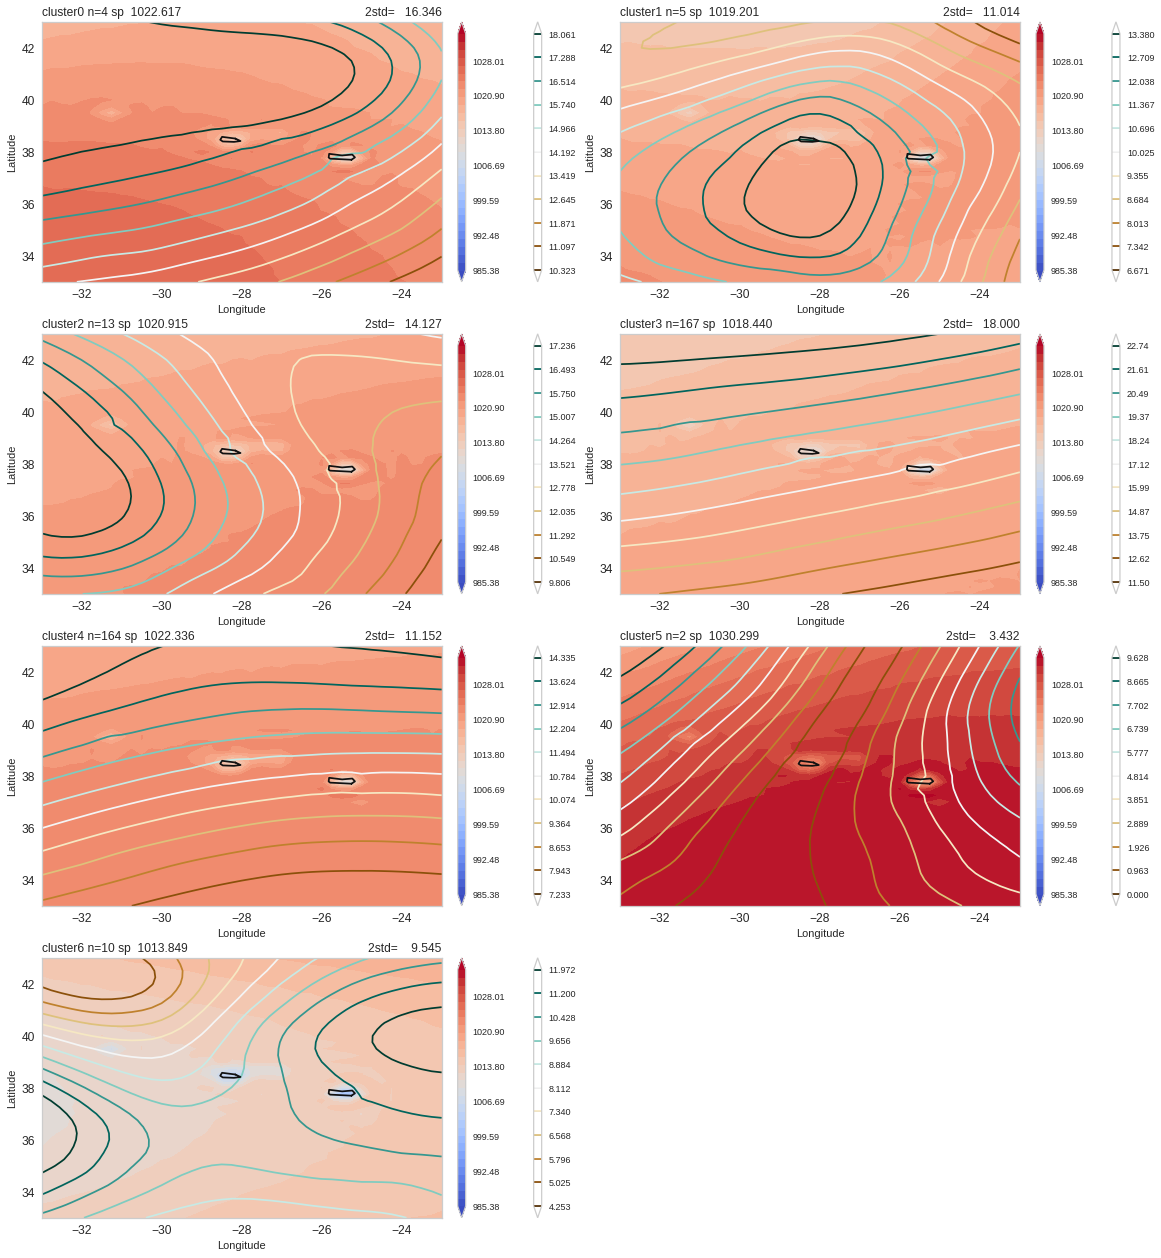

In [ ]:
for ivar in range(len(varids)):
  fig=plt.figure(ivar+1,figsize=[19,22])  
  varid = varids[ivar]  
  var_range=[0,1]
  ccoef = ccoefs[ivar] 
  colorbar = True
  var0 = ccoef*np.squeeze(fin[varid][:])
  ## Fix the range of the values for all of the clusters
  var_range[0]= np.nanmin(var0)+(np.nanmax(var0)-np.nanmin(var0))*0.05
  var_range[1]=np.nanmax(var0)-(np.nanmax(var0)-np.nanmin(var0))*0.05
  print('varid:',varid)
  print('var_range:',var_range)
  ipanel = 0
  for icluster in range(min(id),max(id)+1):
      days_icluster = days[np.where(id==icluster)[0]]
      ndays_icluster = len(days_icluster)
      ## calculate the mean value and standard deviation from the time series of the variable at each (lat,lon)  
      time_icluster = np.zeros(ndays_icluster)
      var_icluster = np.zeros([ndays_icluster,len(lat0),len(lon0)])  
      for iday in range(ndays_icluster):
          istep = np.where(time==days_icluster[iday])
          time_icluster[iday] = time[istep]
          var_icluster[iday]=  np.squeeze(var0[istep])       
      var_mean_icluster = np.nanmean(var_icluster,axis=0)
      var_std_icluster = 2*np.nanstd(var_icluster,axis=0)
           
      title1= 'cluster'+str(icluster)+' n='+ str(len(time_icluster))+' '+varid+' '+ f'{np.nanmean(var_mean_icluster):9.3f}' 
      p = plot_map(var_mean_icluster, var_range,lon0,lat0,fig,panels[ipanel],cmap0,colorbar,title1,ifcontourf=True)
      if(np.nanstd(var_std_icluster)>1e-6*np.nanmean(var_std_icluster)):
          p = plot_map(var_std_icluster, [np.nanmin(var_std_icluster),np.nanmax(var_std_icluster)] ,lon0,lat0,fig,panels[ipanel],'BrBG',colorbar,'2std='+f'{np.nanmean(var_std_icluster):9.3f}',ifcontourf=False)
      else:
          print(np.nanstd(var_std_icluster),np.nanmean(var_std_icluster))
          plt.title('2std='+f'{np.nanmean(var_std_icluster):9.3f}',loc='right')
      ipanel += 1      
  #fig.savefig(varid+'_'+cluster_filename+'.jpg')


#plt.show()

**Plot the time series of the cluster ID:**

Text(0.5, 0, 'Time steps')

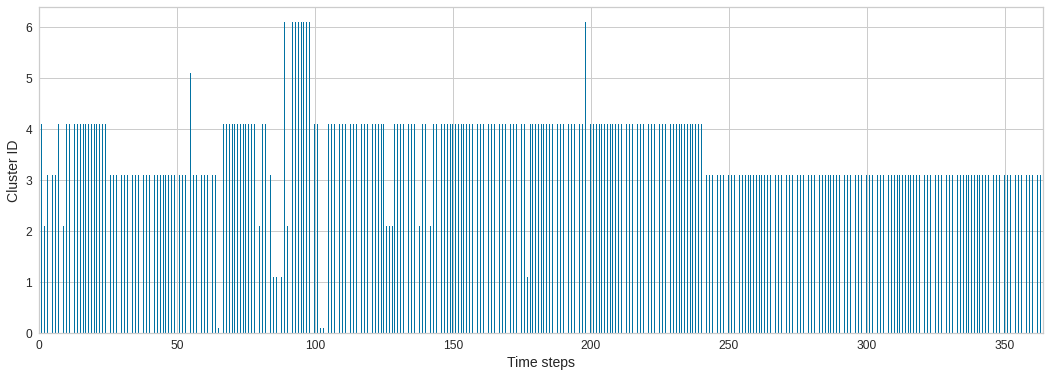

In [ ]:
fig=plt.figure(ivar+2,figsize=[18,6])
plt.bar(days,id+0.1,width=0.3)
plt.tick_params(labelsize=12)
plt.xlim([min(days),max(days)])
plt.ylabel('Cluster ID',fontsize=14)
plt.xlabel('Time steps',fontsize=14)